In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2022-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "GOOG"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


      ID       Date Company Type        Open        High         Low  \
246  246 2023-06-26    GOOG  ACT  121.466003  122.720001  118.989998   
247  247 2023-06-27    GOOG  ACT  117.839996  119.894997  116.910004   
248  248 2023-06-28    GOOG  ACT  117.959999  121.269997  117.599998   
249  249 2023-06-29    GOOG  ACT  120.089996  120.910004  119.209999   
250  250 2023-06-30    GOOG  ACT  121.099998  122.029999  120.879997   

          Close    Volume  
246  119.089996  23185000  
247  119.010002  27221700  
248  121.080002  19753100  
249  120.010002  18517500  
250  120.970001  23865800  


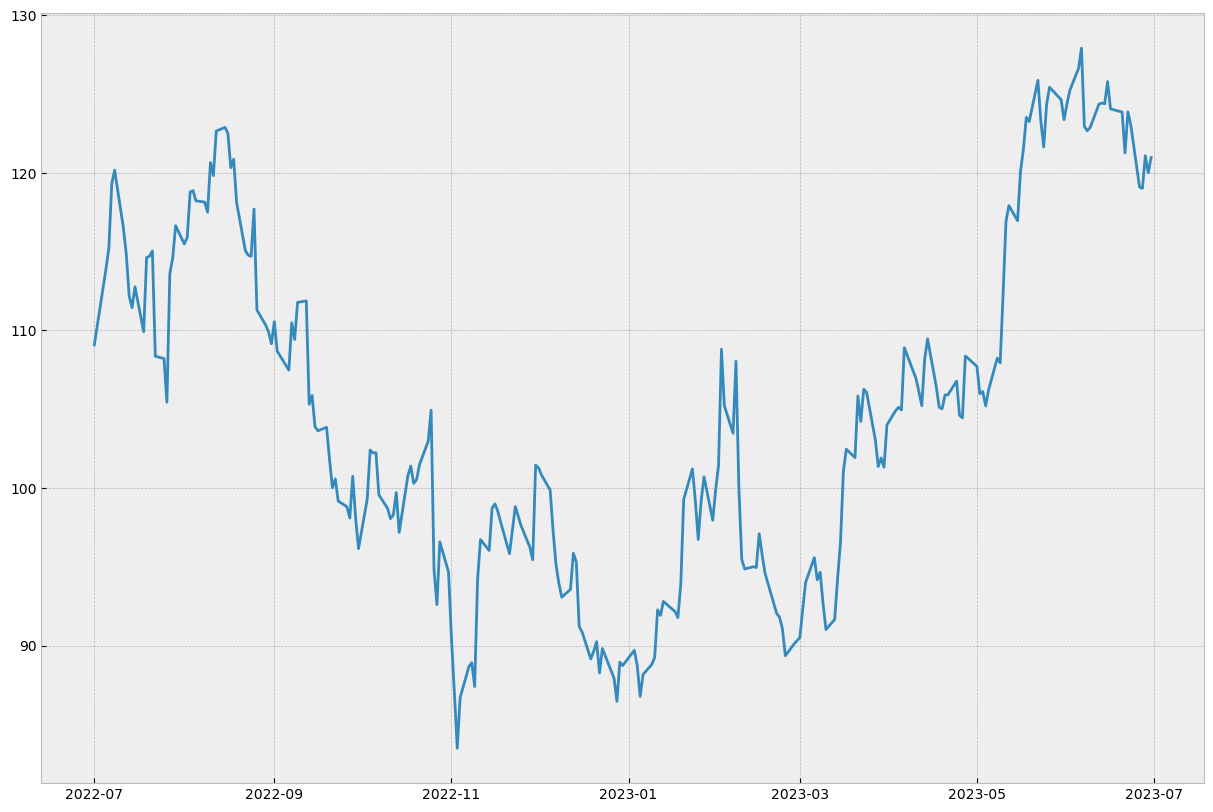

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

In [3]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download stock data
#stock_data = yf.download('GOOG', start='2016-01-01', end='2023-07-01')

# Extract closing prices
close_prices = data['Close']
values = close_prices.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

# Prepare training data
training_data_len = math.ceil(len(values) * 0.8)
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
print(close_prices)

0      109.081001
1      113.887001
2      115.213501
3      119.306000
4      120.168503
          ...    
246    119.089996
247    119.010002
248    121.080002
249    120.010002
250    120.970001
Name: Close, Length: 251, dtype: float64


In [5]:
# Build and train the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
141/141 [==============================] - 6s 17ms/step - loss: 0.0160
Epoch 2/3
141/141 [==============================] - 3s 18ms/step - loss: 0.0091
Epoch 3/3
141/141 [==============================] - 3s 18ms/step - loss: 0.0085


In [6]:
# Prepare test data for predictions
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [7]:
# Generate predictions for the future
future_periods = 30
x_future = x_test[-1]  # Use the last available sequence as the starting point

future_predictions = []
for _ in range(future_periods):
    x_future = np.reshape(x_future, (1, x_future.shape[0], 1))
    future_prediction = model.predict(x_future)
    future_predictions.append(future_prediction[0, 0])
    x_future = np.append(x_future[0][1:], future_prediction)

1/1 [==============================] - 0s 22ms/step


In [8]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Flatten the predictions
predictions_flat = predictions.flatten()

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions_flat  # use flattened predictions here
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions], ignore_index=True)


In [9]:
print(data_extended)

      ID       Date Company Type        Open        High         Low  \
0    0.0 2022-07-01    GOOG  ACT  108.336998  109.806351  107.105003   
1    1.0 2022-07-05    GOOG  ACT  107.514503  114.052597  106.249496   
2    2.0 2022-07-06    GOOG  ACT  114.092003  116.351997  112.250504   
3    3.0 2022-07-07    GOOG  ACT  116.008003  119.862000  115.533997   
4    4.0 2022-07-08    GOOG  ACT  117.550003  120.434998  117.514000   
..   ...        ...     ...  ...         ...         ...         ...   
276  NaN 2023-07-26     NaN  NaN         NaN         NaN         NaN   
277  NaN 2023-07-27     NaN  NaN         NaN         NaN         NaN   
278  NaN 2023-07-28     NaN  NaN         NaN         NaN         NaN   
279  NaN 2023-07-29     NaN  NaN         NaN         NaN         NaN   
280  NaN 2023-07-30     NaN  NaN         NaN         NaN         NaN   

          Close      Volume  
0    109.081001  31028000.0  
1    113.887001  36398000.0  
2    115.213501  28852000.0  
3    119.306000

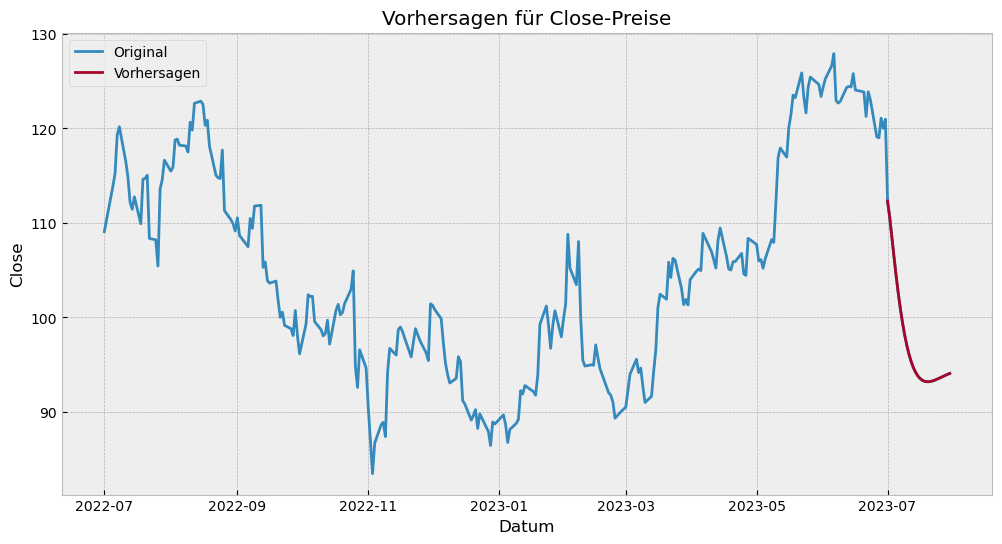

In [10]:
# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
data_extended_key = data_extended

In [12]:
import numpy as np

# Key einbinden
company = data.loc[0]['Company']
data_extended_key['Company'] = company
data_extended_key['Type'] = data_extended_key['High'].apply(lambda x: f'LSTM_{company}' if np.isnan(x) else f'Act_{company}')
data_extended_key.loc[data_extended_key['Type'].str.contains('LSTM'), 'Forecast_Date'] = end_date
data_extended_key['Key'] = data_extended_key['Company'] + '_' + data_extended_key['Date'].astype(str) + '_' + data_extended_key['Type']


In [13]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(data_extended.dtypes)
exists_df = exists_df.reindex(columns=data_extended.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

In [14]:
exists_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Forecast_Date,Key
0,68.0,2020-10-07,GOOG,Act_GOOG,73.2145,73.448,71.800,73.014503,34924000.0,None,GOOG_2020-10-07_Act_GOOG
1,205.0,2021-04-26,GOOG,Act_GOOG,115.9960,117.063,115.692,116.336998,20834000.0,None,GOOG_2021-04-26_Act_GOOG
2,NaN,2023-01-20,GOOG,Act_GOOG,95.9500,99.420,95.910,99.279999,53704800.0,None,GOOG_2023-01-20_Act_GOOG
3,341.0,2021-11-05,GOOG,Act_GOOG,149.3540,150.571,148.652,149.240997,20408000.0,None,GOOG_2021-11-05_Act_GOOG
4,477.0,2022-05-23,GOOG,Act_GOOG,110.1040,112.006,109.154,111.666496,31558000.0,None,GOOG_2022-05-23_Act_GOOG
...,...,...,...,...,...,...,...,...,...,...,...
3220,NaN,2023-03-27,GOOG,LSTM_GOOG,NaN,NaN,NaN,103.059998,NaN,2023-05-01,GOOG_2023-03-27_LSTM_GOOG
3221,NaN,2023-03-28,GOOG,LSTM_GOOG,NaN,NaN,NaN,101.360001,NaN,2023-05-01,GOOG_2023-03-28_LSTM_GOOG
3222,NaN,2023-03-29,GOOG,LSTM_GOOG,NaN,NaN,NaN,101.900002,NaN,2023-05-01,GOOG_2023-03-29_LSTM_GOOG
3223,NaN,2023-03-30,GOOG,LSTM_GOOG,NaN,NaN,NaN,101.320000,NaN,2023-05-01,GOOG_2023-03-30_LSTM_GOOG


In [14]:
# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended_key])



In [15]:
# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

In [16]:
# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 58 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.
